# <center>EE655000 Machine Learning HW1</center> #
####  EE 107061212 劉亦傑
***

### Load the wine dataset
* 首先，我先將import所需要的套件，並利用pandas將wine.csv讀進來，再將其輸出初步了解dataset狀況。
* 接著，我利用Python的Counter套件，去檢查wine dataset的label是否為1, 2, 3，以及這三個labels的分布情形。

In [91]:
import numpy as np
import pandas as pd
import random
import scipy.stats as st
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

df_wine = pd.read_csv("Wine.csv", header = None)
print('Understand the wine dataset first.')
df_wine

Understand the wine dataset first.


,0,1,2,3,4,5,6,7,8,9,10,11,12,13
0,1,14.23,1.71,2.43,15.6,127,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065
1,1,13.20,1.78,2.14,11.2,100,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050
2,1,13.16,2.36,2.67,18.6,101,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185
3,1,14.37,1.95,2.50,16.8,113,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480
4,1,13.24,2.59,2.87,21.0,118,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
173,3,13.71,5.65,2.45,20.5,95,1.68,0.61,0.52,1.06,7.70,0.64,1.74,740
174,3,13.40,3.91,2.48,23.0,102,1.80,0.75,0.43,1.41,7.30,0.70,1.56,750
175,3,13.27,4.28,2.26,20.0,120,1.59,0.69,0.43,1.35,10.20,0.59,1.56,835
176,3,13.17,2.59,2.37,20.0,120,1.65,0.68,0.53,1.46,9.30,0.60,1.62,840


In [92]:
from collections import Counter
labels = df_wine.iloc[:, 0].values
label_kinds = np.unique(labels)
print(f'Wine labels: {label_kinds}')
label_cnt = Counter(labels)
for i in range(len(label_kinds)):
    print(f'The numbers of {i + 1}-th label: {label_cnt[label_kinds[i]]} ')

Wine labels: [1 2 3]
The numbers of 1-th label: 59 
The numbers of 2-th label: 71 
The numbers of 3-th label: 48 


### Split the train and test data

* 首先由前述可以得知3種labels的分布情形，因此能切分出三個變數分別都僅含其中一種label的資料。然後，照著PDF敘述先進行random shuffle，並從三個類別分別取出其中18個instances，利用np.concatenate就能獲得testing data，剩餘的資料則為training data。
* 接著根據PDF敘述，把training data, testing data分別存成train.csv, test.csv進行繳交。
* 注意到資料的第一個columns為label，而我的實作上要將其型別轉換為int32；而剩餘的columns則作為用來分類的13個特徵。
* 最後印出training data和testing data的shape來確認資料切分是否正確。

In [93]:
X_wine = df_wine.iloc[:, range(0, 14)].values
X_1, X_2, X_3 = X_wine[:59], X_wine[59:59+71], X_wine[59+71:]
np.random.shuffle(X_1)
np.random.shuffle(X_2)
np.random.shuffle(X_3)

X_test = np.concatenate((X_1[:18], X_2[:18], X_3[:18]))
X_train = np.concatenate((X_1[18:], X_2[18:], X_3[18:]))

pd.DataFrame(X_test).to_csv('test.csv', index=False, header=False)
pd.DataFrame(X_train).to_csv('train.csv', index=False, header=False)

# obtain label
y_train = X_train[:, 0].astype(dtype=np.int32)
y_test = X_test[:, 0].astype(dtype=np.int32)

# remove the column of labels
X_train = X_train[:, 1:] 
X_test = X_test[:, 1:]
print(f'Training set: {X_train.shape}, Testing set: {X_test.shape}')

Training set: (124, 13), Testing set: (54, 13)


### Calculate prior and likelihood
* 根據training set的labels分布，除上training set的總數，可以計算出三者的prior。
* 接著利用training set和labels的資訊，計算出個別的mean, variance，再使用scipy的norm去建立Gaussian distribution的關係，即可學習到likelihood的資訊。

In [94]:
# calculate the prior
labels = list(Counter(y_train).values())
print(f'Distribution of labels: {labels}')
prior = [val / X_train.shape[0] for val in labels]
print(f'Prior probability: {prior}')

# calculate the likelihood
def cal_likelihood(X, l):
    likelihood_dis = [[], [], []]
    for idx in range(X.shape[1]):
        # print(X_train[:labels[0], idx].shape)
        # label 1
        mean_1 = np.mean(X[:l[0], idx])
        std_1 = np.std(X[:l[0], idx])
        # label 2
        mean_2 = np.mean(X[l[0]:l[0]+l[1], idx])
        std_2 = np.std(X[l[0]:l[0]+l[1], idx])
        # label 3
        mean_3 = np.mean(X[l[0]+l[1]:l[0]+l[1]+l[2], idx])
        std_3 = np.std(X[l[0]+l[1]:l[0]+l[1]+l[2], idx])
        likelihood_dis[0].append(st.norm(mean_1, std_1).pdf)
        likelihood_dis[1].append(st.norm(mean_2, std_2).pdf)
        likelihood_dis[2].append(st.norm(mean_3, std_3).pdf)
    return likelihood_dis

# obtain the likelihood distribution
likelihood = cal_likelihood(X_train, labels)

Distribution of labels: [41, 53, 30]
Prior probability: [0.33064516129032256, 0.4274193548387097, 0.24193548387096775]


### Calculate posterior probability and predict
* posterior計算的部分，首先我會先從testing set取出每個instance，並根據講義的公式計算
$$P(\theta|D)=\mathop{\arg\max}\limits_{\theta}\frac{P(D|\theta)P(\theta)}{P(D)}$$
> $P(\theta|D)$: posterior; $P(D|\theta)$: likelihood; $P(\theta)$: prior; $P(D)$: evidence
* 由上式可以得知，$P(\theta|D) \propto P(D|\theta)P(\theta)$
* 因此，計算posterior來分類如同下式
$$P(\theta|D)=P(d_1|\theta)\times P(d_2|\theta)\times...\times P(d_n|\theta) \times P(\theta)$$
* 最後，去比較prediction的labels和ground truth，就可以計算出accuracy。

In [95]:
'''
How I obtain the posterior probability:
    From testing set, I iterate the testing dataset first.
    For each instance from testing set, I will calculate 3 posteriors.
    First, multiply posterior by prior values.
    Second, for each feature (totally 13 features), I multiply posterior to the likelihood.
    (Note: I just use the likelihood value directly instead of integrate it)
    Then, I take the argmax of these 3 posteriors to find the prediction label.
    Finally, compare the prediction labels with ground truth labels to find the accuracy.
'''
prediction = []
for ins in X_test:
    posterior_arr = []
    for i in range(3):
        posterior = 1. * prior[i]
        for idx in range(X_train.shape[1]):
            test_val = ins[idx]
            posterior *= likelihood[i][idx](test_val)
        posterior_arr.append(posterior)
    prediction.append(np.argmax(posterior_arr) + 1)

acc_ori = 0
for i in range(len(prediction)):
    if prediction[i] == y_test[i]:
        acc_ori += 1
print(f'Accuracy: {acc_ori / len(prediction) * 100:.1f} %')


Accuracy: 100.0 %


### Visualized testing dataset by PCA in 2D and 3D
* 利用sklearn.decomposition去畫出PCA的結果。
* 我額外實作了plot_PCA的function來方便我作圖，此函數會用testing set的data、labels來畫圖，以及利用is_3d這個flag來方便我選擇要畫2D還是3D的圖。
* 而我會於PCA function設定n_components=2來畫2D的圖，以及n_components=3來畫3D的圖


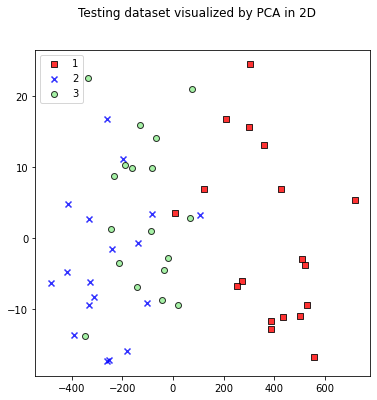

In [96]:
from sklearn.decomposition import PCA

def plot_PCA(X, y, is_3d=False):
    # setup marker generator and color map
    markers = ('s', 'x', 'o', '^', 'v')
    colors = ('red', 'blue', 'lightgreen', 'gray', 'cyan')
    cmap = ListedColormap(colors[:len(np.unique(y))])

    # plot the decision surface
    for idx, cl in enumerate(np.unique(y)):
        if is_3d == True:
            ax.scatter(X[y == cl, 0], 
                    X[y == cl, 1],
                    X[y == cl, 2],
                    alpha=0.8, 
                    c=colors[idx],
                    marker=markers[idx], 
                    label=cl, 
                    edgecolor='black') 
        else:
            plt.scatter(X[y == cl, 0], 
                        X[y == cl, 1],
                        alpha=0.8, 
                        c=colors[idx],
                        marker=markers[idx], 
                        label=cl, 
                        edgecolor='black')

pca_func = PCA(n_components=2)
X_test_pca = pca_func.fit_transform(X_test)
# X_test_pca.shape
fig = plt.figure(figsize=(6,6))
plt.suptitle('Testing dataset visualized by PCA in 2D')
# Plot the scatter graph to understand the PCA in 2D
plot_PCA(X_test_pca, y_test, is_3d=False)
plt.legend(loc='upper left')
plt.savefig('pca_2d.png', dpi=300)



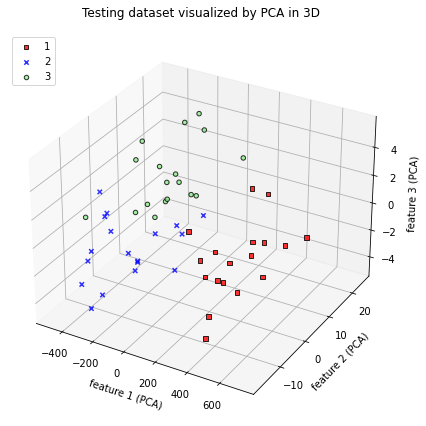

In [97]:
pca3_func = PCA(n_components=3)
X_test_pca3 = pca3_func.fit_transform(X_test)
# X_test_pca3.shape
fig2 = plt.figure(figsize=(6,6))
plt.suptitle('Testing dataset visualized by PCA in 3D')
ax = fig2.add_subplot(projection='3d')

# Plot the scatter graph to understand the PCA in 3D   
plot_PCA(X_test_pca3, y_test, is_3d=True)
ax.set_xlabel('feature 1 (PCA)')
ax.set_ylabel('feature 2 (PCA)')
ax.set_zlabel('feature 3 (PCA)')
plt.legend(loc='upper left')
plt.tight_layout()
plt.savefig('pca_3d.png', dpi=300)

### Discussion about the effect of prior on posterior probability
* 以下實驗將會嘗試改變training set的比例，也就能改變prior，來觀察是否影響到posterior以及accuracy。
* 我嘗試將第1個label的個數及第3個label的個數減少，如此一來training set會變得很不均勻，如此一來prior也會被大幅改變。
* 接著，類似前面的題目，利用不均勻的training set去計算likelihood。
* 理論上如此不均勻的prior，代表著training data和testing data分布差距很大，應該導致MAP estimator會預測失準，但從第一輪的實驗來看，其accuracy似乎沒有明顯的落差。
* 而上述現象，我認為可能是因為wine dataset具有13個features，進而導致likelihood對posterior影響較大，所以我嘗試減少likelihood取的feature數量(至4個)。
* 減少至4個feature後，可以發現到最後的accuracy明顯有下降，也就能代表將likelihood對posterior的影響降低後，自然最後的posterior會比較容易受到prior影響，而不均勻的prior就會有預測不準的現象。

In [98]:
X_train_n_bal = np.concatenate((X_train[30:100,:], X_train[110:,:]))
y_train_n_bal = np.concatenate((y_train[30:100], y_train[110:]))
labels = list(Counter(y_train_n_bal).values())
print(f'Distribution of labels: {labels}')
prior = [val / X_train_n_bal.shape[0] for val in labels]
print(f'Prior probability: {prior}')

likelihood = cal_likelihood(X_train_n_bal, labels)
# X_train.shape
# X_train_n_bal.shape

Distribution of labels: [11, 53, 20]
Prior probability: [0.13095238095238096, 0.6309523809523809, 0.23809523809523808]


In [99]:
prediction = []
for ins in X_test:
    posterior_arr = []
    for i in range(3):
        posterior = 1. * prior[i]
        for idx in range(13):
            test_val = ins[idx]
            posterior *= likelihood[i][idx](test_val)
        posterior_arr.append(posterior)
    prediction.append(np.argmax(posterior_arr) + 1)

acc_test = 0
for i in range(len(prediction)):
    if prediction[i] == y_test[i]:
        acc_test += 1
print(f'Original accuracy: {acc_ori / len(prediction) * 100:.1f} %')
print(f'After changing prior, accuracy: {acc_test / len(prediction) * 100:.1f} %')

Original accuracy: 100.0 %
After changing prior, accuracy: 98.1 %


In [100]:
prediction = []
for ins in X_test:
    posterior_arr = []
    for i in range(3):
        posterior = 1. * prior[i]
        for idx in range(4): # only use 4 features (likelihoods)
            test_val = ins[idx]
            posterior *= likelihood[i][idx](test_val)
        posterior_arr.append(posterior)
    prediction.append(np.argmax(posterior_arr) + 1)

acc_test = 0
for i in range(len(prediction)):
    if prediction[i] == y_test[i]:
        acc_test += 1
print(f'Original accuracy: {acc_ori / len(prediction) * 100:.1f} %')
print(f'After changing prior and number of features, accuracy: {acc_test / len(prediction) * 100:.1f} %')

Original accuracy: 100.0 %
After changing prior and number of features, accuracy: 88.9 %
